# Group assignment: Using unstructured data for sentiment analysis
## Group 10

In [20]:
import os
import pickle
import pandas as pd
import spacy
import numpy as np
import gc
from tqdm import tqdm
import yfinance as yf
import requests
import time
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import matplotlib.pyplot as plt

In [22]:
# Load the SpaCy small model (less memory usage)
nlp = spacy.load('en_core_web_sm')

LM_file_name = 'LoughranMcDonald_SentimentWordLists_2018.xlsx'
# Load the sentiment word lists from the Loughran-McDonald Excel file
LM_negative = pd.read_excel(LM_file_name, sheet_name='Negative', header=None)
LM_positive = pd.read_excel(LM_file_name, sheet_name='Positive', header=None)
LM_uncertainty = pd.read_excel(LM_file_name, sheet_name='Uncertainty', header=None)

# Convert the word lists to lowercase sets for faster lookup and better matching
LM_positive_set = set(LM_positive.squeeze().str.lower().tolist())
LM_negative_set = set(LM_negative.squeeze().str.lower().tolist())
LM_uncertainty_set = set(LM_uncertainty.squeeze().str.lower().tolist())

# Titles to search for in participant descriptions
ceo_titles = ['CEO', 'Chief Executive', 'President', 'Chairman']
analyst_titles = ['Analyst', 'Research', 'Equity Analyst']

# Function to extract roles from participant descriptions
def count_roles(participants):
    ceo_count = 0
    analyst_count = 0
    other_count = 0

    for participant in participants:
        description = participant.get('description', '').lower()

        if any(title.lower() in description for title in ceo_titles):
            ceo_count += 1
        elif any(title.lower() in description for title in analyst_titles):
            analyst_count += 1
        else:
            other_count += 1
    
    return {'CEO': ceo_count, 'Analyst': analyst_count, 'Other': other_count}

# Define the sentiment scoring function
def score_transcript(text):
    words = text.split()
    number_of_words = len(words)

    if number_of_words == 0:
        return 0.0, 0.0, 0.0

    counts = pd.Series(words).value_counts()
    keys = set(counts.index)

    pos = round((sum([counts[k] for k in (keys & LM_positive_set)]) / number_of_words), 4)
    neg = round((sum([counts[k] for k in (keys & LM_negative_set)]) / number_of_words), 4)
    unc = round((sum([counts[k] for k in (keys & LM_uncertainty_set)]) / number_of_words), 4)

    return pos, neg, unc

# Preprocess text using batch processing in SpaCy to reduce memory load
def preprocess_batch_texts(texts):
    max_length = 10_000  # Limit transcript length to avoid kernel crashes
    processed_texts = []

    docs = nlp.pipe([text[:max_length].lower() for text in texts], batch_size=10)  # Larger batch size for better performance

    for doc in docs:
        words = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or token.is_space)]
        processed_texts.append(' '.join(words))

    return processed_texts

# Combined function to extract transcript text and roles
def extract_text_and_roles(transcripts):
    texts, times, roles = [], [], []
    for t in transcripts:
        text = ' '.join(speech['speech'][0] for speech in t['transcript'])
        texts.append(text)
        times.append(t['time'])
        roles.append(count_roles(t['participant']))
    return texts, times, roles

# Directory where the .p files are stored
directory = 'transcripts/'

# Group 10 tickers
tickers = ['BLK', 'MDT', 'AZN', 'BKNG', 'MA', 'CHTR', 'JNJ', 'CRM', 'TMO', 'UNH', 'NKE', 'NVO', 'AMGN', 'ORCL', 'UPS', 'IBM',
           'MCD', 'LMT', 'EL', 'PEP', 'GS', 'LOW', 'XOM', 'INTC', 'CMCSA', 'JPM', 'NVS', 'COST', 'KO', 'WFC', 'GM',
           'UNP', 'TMUS', 'TSLA', 'ASML', 'ADBE', 'MRK', 'DUK', 'MET', 'ABBV']

# DataFrame to store sentiment scores
sentiment_scores = pd.DataFrame(columns=['date', 'ticker', 'pos', 'neg', 'unc', 'ceo_ratio', 'analyst_ratio'])

# Initialize progress bar
with tqdm(total=len(tickers), desc="Processing Tickers", unit="ticker") as pbar:

    # Loop through each ticker in Group 10
    for ticker in tickers:
        file_path = os.path.join(directory, f"{ticker}.p")

        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                transcripts = pickle.load(f)

            if transcripts is not None and len(transcripts) > 0:
                transcripts_texts, times, roles = extract_text_and_roles(transcripts)

                if transcripts_texts and times:
                    clean_texts = preprocess_batch_texts(transcripts_texts)

                    for i, clean_text in enumerate(clean_texts):
                        scores = score_transcript(clean_text)
                        role_counts = roles[i]
                        total_roles = sum(role_counts.values())
                        ceo_ratio = role_counts['CEO'] / total_roles if total_roles > 0 else 0
                        analyst_ratio = role_counts['Analyst'] / total_roles if total_roles > 0 else 0

                        # Append scores and ratios to DataFrame
                        new_row = pd.DataFrame([[pd.to_datetime(times[i]), ticker, *scores, ceo_ratio, analyst_ratio]],
                                                columns=['date', 'ticker', 'pos', 'neg', 'unc', 'ceo_ratio', 'analyst_ratio'])
                        
                        if sentiment_scores.empty:
                            sentiment_scores = new_row
                        elif (not sentiment_scores.empty) and (not new_row.empty):
                            sentiment_scores = pd.concat([sentiment_scores, new_row]).reset_index(drop=True)

                    gc.collect()  # Memory management after each ticker
            else:
                print(f"No transcripts found for {ticker}")
        else:
            print(f"File for {ticker} not found!")

        # Update progress bar
        pbar.update(1)

# Check if the DataFrame has any data before writing to the final CSV
if not sentiment_scores.empty:
    sentiment_scores.to_csv('base_sentiment_scores_group10.csv', index=False)   # Save the final sentiment scores
    sentiment_scores.to_csv('sentiment_scores_group10.csv', index=False)        # Save a copy for the next step
    print("Final sentiment scores saved to 'base_sentiment_scores_group10.csv'.")
    print("A copy of the sentiment scores has been saved to 'sentiment_scores_group10.csv'.")
else:
    print("No data found!")


Processing Tickers: 100%|██████████| 40/40 [04:28<00:00,  6.72s/ticker]

Final sentiment scores saved to 'base_sentiment_scores_group10.csv'.
A copy of the sentiment scores has been saved to 'sentiment_scores_group10.csv'.


In [23]:
# Load the base data frame from the CSV file
data_frame = pd.read_csv('base_sentiment_scores_group10.csv')

def multi_index(data_frame):
    data_frame['date'] = pd.to_datetime(data_frame['date'])
    data_frame.set_index(['ticker', 'date'], inplace=True)
    data_frame.sort_index(inplace=True)

    data_frame.to_csv('sentiment_scores_group10.csv', index=True)   # Save a copy for the next step
    return data_frame

# Usage
sentiment_score = multi_index(data_frame)
sentiment_score.head()

pos     neg     unc  ceo_ratio  analyst_ratio
ticker date                                                                 
ABBV   2013-03-13 23:56:19  0.0222  0.0250  0.0180   0.000000            0.0
       2013-04-26 16:01:16  0.0308  0.0262  0.0137   0.071429            0.0
       2013-05-15 03:26:07  0.0437  0.0159  0.0106   0.666667            0.0
       2013-06-13 23:59:05  0.0530  0.0149  0.0109   0.000000            0.0
       2013-07-26 17:10:06  0.0291  0.0190  0.0101   0.333333            0.0

In [24]:
def add_net_sentiment(data_frame):
    data_frame['net_sentiment'] = data_frame['pos'] - data_frame['neg'] # Calculate net sentiment
    data_frame.to_csv('sentiment_scores_group10.csv')   # Update CSV
    return data_frame

# Usage
sentiment_score = add_net_sentiment(data_frame)
sentiment_score

pos     neg     unc  ceo_ratio  analyst_ratio  \
ticker date                                                                    
ABBV   2013-03-13 23:56:19  0.0222  0.0250  0.0180   0.000000       0.000000   
       2013-04-26 16:01:16  0.0308  0.0262  0.0137   0.071429       0.000000   
       2013-05-15 03:26:07  0.0437  0.0159  0.0106   0.666667       0.000000   
       2013-06-13 23:59:05  0.0530  0.0149  0.0109   0.000000       0.000000   
       2013-07-26 17:10:06  0.0291  0.0190  0.0101   0.333333       0.000000   
...                            ...     ...     ...        ...            ...   
XOM    2020-05-01 20:00:40  0.0391  0.0297  0.0067   0.181818       0.090909   
       2020-05-27 21:59:15  0.0255  0.0352  0.0036   0.250000       0.000000   
       2020-07-31 17:59:08  0.0333  0.0247  0.0118   0.000000       0.090909   
       2020-10-30 21:24:08  0.0496  0.0285  0.0074   0.000000       0.090909   
       2021-02-03 02:56:06  0.0457  0.0261  0.0120   0.222222       0.111111   

                            net_sentiment  
ticker date                                
ABBV   2013-03-13 23:56:19        -0.0028  
       2013-04-26 16:01:16         0.0046  
       2013-05-15 03:26:07         0.0278  
       2013-06-13 23:59:05         0.0381  
       2013-07-26 17:10:06         0.0101  
...                                   ...  
XOM    2020-05-01 20:00:40         0.0094  
       2020-05-27 21:59:15        -0.0097  
       2020-07-31 17:59:08         0.0086  
       2020-10-30 21:24:08         0.0211  
       2021-02-03 02:56:06         0.0196  

[2804 rows x 6 columns]

In [25]:
def add_sector(data_frame):
    # Get the industry sector for each ticker
    unique_tickers = data_frame.index.get_level_values('ticker').unique()
    ticker_sector = {}

    # Fetch industry sector for each ticker
    for ticker in unique_tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            sector = info.get('sector', np.nan)
            ticker_sector[ticker] = sector
        except Exception as e:
            ticker_sector[ticker] = np.nan
            print(f'Error getting info for {ticker}: {e}')

    # Map the industry sector to each ticker in the sentiment_scores DataFrame
    data_frame['sector'] = data_frame.index.get_level_values('ticker').map(ticker_sector)
    
    data_frame.to_csv('sentiment_scores_group10.csv')  # Update CSV
    return data_frame

# Usage
sentiment_score = add_sector(sentiment_score)
sentiment_score

pos     neg     unc  ceo_ratio  analyst_ratio  \
ticker date                                                                    
ABBV   2013-03-13 23:56:19  0.0222  0.0250  0.0180   0.000000       0.000000   
       2013-04-26 16:01:16  0.0308  0.0262  0.0137   0.071429       0.000000   
       2013-05-15 03:26:07  0.0437  0.0159  0.0106   0.666667       0.000000   
       2013-06-13 23:59:05  0.0530  0.0149  0.0109   0.000000       0.000000   
       2013-07-26 17:10:06  0.0291  0.0190  0.0101   0.333333       0.000000   
...                            ...     ...     ...        ...            ...   
XOM    2020-05-01 20:00:40  0.0391  0.0297  0.0067   0.181818       0.090909   
       2020-05-27 21:59:15  0.0255  0.0352  0.0036   0.250000       0.000000   
       2020-07-31 17:59:08  0.0333  0.0247  0.0118   0.000000       0.090909   
       2020-10-30 21:24:08  0.0496  0.0285  0.0074   0.000000       0.090909   
       2021-02-03 02:56:06  0.0457  0.0261  0.0120   0.222222       0.111111   

                            net_sentiment      sector  
ticker date                                            
ABBV   2013-03-13 23:56:19        -0.0028  Healthcare  
       2013-04-26 16:01:16         0.0046  Healthcare  
       2013-05-15 03:26:07         0.0278  Healthcare  
       2013-06-13 23:59:05         0.0381  Healthcare  
       2013-07-26 17:10:06         0.0101  Healthcare  
...                                   ...         ...  
XOM    2020-05-01 20:00:40         0.0094      Energy  
       2020-05-27 21:59:15        -0.0097      Energy  
       2020-07-31 17:59:08         0.0086      Energy  
       2020-10-30 21:24:08         0.0211      Energy  
       2021-02-03 02:56:06         0.0196      Energy  

[2804 rows x 7 columns]

In [26]:
def add_market_data(data_frame):
    # Add a temporary column for date only for merging with market data
    data_frame['date_only'] = data_frame.index.get_level_values('date').date

    # Get the start date from the sentiment data
    date_start = data_frame.index.get_level_values('date').min()

    # Get the unique tickers from sentiment_scores
    unique_tickers = data_frame.index.get_level_values('ticker').unique()

    # Initialize empty DataFrame to store market data for all tickers
    market_data_all = pd.DataFrame()

    for ticker in unique_tickers:
        try:
            # Download market data using yfinance
            market_data = yf.download(ticker, start=date_start)
            market_data['returns_market'] = market_data['Adj Close'].pct_change()

            # Convert index to date for matching with sentiment data
            market_data['date'] = market_data.index.date
            market_data['ticker'] = ticker
            market_data.set_index(['ticker', 'date'], inplace=True)

            # Append market data for this ticker to the total market data
            market_data_all = pd.concat([market_data_all, market_data[['Adj Close', 'returns_market']]])
        except Exception as e:
            print(f'Error fetching data for {ticker}: {e}')

    # Merge market data with the sentiment data and fill any missing values
    data_frame = data_frame.merge(market_data_all, left_on=['ticker', 'date_only'], right_index=True, how='left')
    data_frame.drop(columns=['date_only'], inplace=True)  # Drop the temporary date_only column

    # Calculate rolling correlation between net sentiment and returns for each ticker
    window_size = 4
    data_frame['rolling_corr_net_sent'] = np.nan  # Initialize column

    # Group by ticker and calculate rolling correlation within each group
    for ticker, group in data_frame.groupby('ticker'):
        group = group.sort_values(by='date')  # Ensure the data is sorted by date
        rolling_corr = group['returns_market'].rolling(window=window_size).corr(group['net_sentiment'])

        # Update the rolling correlation values in the main DataFrame
        data_frame.loc[(ticker, slice(None)), 'rolling_corr_net_sent'] = rolling_corr

    # Fill any remaining NaN values in rolling_corr_net_sent (optional)
    data_frame['rolling_corr_net_sent'] = data_frame['rolling_corr_net_sent']

    data_frame.to_csv('sentiment_scores_group10.csv')  # Update CSV
    return data_frame

# Usage
sentiment_score = add_market_data(sentiment_score)
sentiment_score.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

pos     neg     unc  ceo_ratio  analyst_ratio  \
ticker date                                                                    
ABBV   2013-03-13 23:56:19  0.0222  0.0250  0.0180   0.000000            0.0   
       2013-04-26 16:01:16  0.0308  0.0262  0.0137   0.071429            0.0   
       2013-05-15 03:26:07  0.0437  0.0159  0.0106   0.666667            0.0   
       2013-06-13 23:59:05  0.0530  0.0149  0.0109   0.000000            0.0   
       2013-07-26 17:10:06  0.0291  0.0190  0.0101   0.333333            0.0   

                            net_sentiment      sector  Adj Close  \
ticker date                                                        
ABBV   2013-03-13 23:56:19        -0.0028  Healthcare  23.164219   
       2013-04-26 16:01:16         0.0046  Healthcare  28.831724   
       2013-05-15 03:26:07         0.0278  Healthcare  28.951223   
       2013-06-13 23:59:05         0.0381  Healthcare  27.139814   
       2013-07-26 17:10:06         0.0101  Healthcare  28.430294   

                            returns_market  rolling_corr_net_sent  
ticker date                                                        
ABBV   2013-03-13 23:56:19        0.000000                    NaN  
       2013-04-26 16:01:16        0.036166                    NaN  
       2013-05-15 03:26:07        0.014995                    NaN  
       2013-06-13 23:59:05        0.008885              -0.106589  
       2013-07-26 17:10:06        0.012432              -0.721565

In [27]:
def add_recommendation_mean(data_frame):
    # Get unique tickers from the DataFrame
    unique_tickers = data_frame.index.get_level_values('ticker').unique()
    ticker_recommendation_mean = {}

    # Fetch recommendation mean for each unique ticker
    for ticker in unique_tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            recommendation_mean = info.get('recommendationMean', np.nan)  # Get recommendationMean or set to NaN if not found
            ticker_recommendation_mean[ticker] = recommendation_mean
        except Exception as e:
            ticker_recommendation_mean[ticker] = np.nan  # Set to NaN on error
            print(f'Error getting recommendation for {ticker}: {e}')

    # Map the recommendation mean to the DataFrame
    data_frame['recommendation_mean'] = data_frame.index.get_level_values('ticker').map(ticker_recommendation_mean)

    data_frame.to_csv('sentiment_scores_group10.csv')  # Update CSV
    return data_frame

# Usage
sentiment_score = add_recommendation_mean(sentiment_score)
sentiment_score.head()

pos     neg     unc  ceo_ratio  analyst_ratio  \
ticker date                                                                    
ABBV   2013-03-13 23:56:19  0.0222  0.0250  0.0180   0.000000            0.0   
       2013-04-26 16:01:16  0.0308  0.0262  0.0137   0.071429            0.0   
       2013-05-15 03:26:07  0.0437  0.0159  0.0106   0.666667            0.0   
       2013-06-13 23:59:05  0.0530  0.0149  0.0109   0.000000            0.0   
       2013-07-26 17:10:06  0.0291  0.0190  0.0101   0.333333            0.0   

                            net_sentiment      sector  Adj Close  \
ticker date                                                        
ABBV   2013-03-13 23:56:19        -0.0028  Healthcare  23.164219   
       2013-04-26 16:01:16         0.0046  Healthcare  28.831724   
       2013-05-15 03:26:07         0.0278  Healthcare  28.951223   
       2013-06-13 23:59:05         0.0381  Healthcare  27.139814   
       2013-07-26 17:10:06         0.0101  Healthcare  28.430294   

                            returns_market  rolling_corr_net_sent  \
ticker date                                                         
ABBV   2013-03-13 23:56:19        0.000000                    NaN   
       2013-04-26 16:01:16        0.036166                    NaN   
       2013-05-15 03:26:07        0.014995                    NaN   
       2013-06-13 23:59:05        0.008885              -0.106589   
       2013-07-26 17:10:06        0.012432              -0.721565   

                            recommendation_mean  
ticker date                                      
ABBV   2013-03-13 23:56:19                  2.2  
       2013-04-26 16:01:16                  2.2  
       2013-05-15 03:26:07                  2.2  
       2013-06-13 23:59:05                  2.2  
       2013-07-26 17:10:06                  2.2

In [28]:
# Calculate the mean for each ticker of net_sentiment and recommendation_mean
def extract_sent_rec_mean(data_frame):
    # Calculate the mean for each ticker of net_sentiment and recommendation_mean
    df_result = data_frame.groupby('ticker')[['net_sentiment', 'recommendation_mean']].mean()
    return df_result

# Usage
sent_rec_mean = extract_sent_rec_mean(sentiment_score)
sent_rec_mean.head()

,net_sentiment,recommendation_mean
ticker,,
ABBV,0.027175,2.2
ADBE,0.037770,2.0
AMGN,0.024226,2.3
ASML,0.010616,1.8
AZN,0.019918,1.7


In [29]:
# P/E Data fetching using HTML requests
sentiment_score = pd.read_csv('sentiment_scores_group10.csv', index_col=['ticker', 'date'], parse_dates=['date'])

def extract_pe_data(data_frame):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}

    # Get unique tickers from the DataFrame
    unique_tickers = data_frame.index.get_level_values('ticker').unique()
    df_pe_ratio = pd.DataFrame()
    error_tickers = []

    # Setup retry strategy to handle connection errors
    retry_strategy = Retry(
        total=5,
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"]
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    http = requests.Session()
    http.mount("https://", adapter)
    http.mount("http://", adapter)

    for ticker in unique_tickers:
        try:
            time.sleep(1.5)  # Sleep for 1.5 seconds to avoid hitting the server too frequently
            company_name = yf.Ticker(ticker).info['shortName'].split(' ')[0].lower().replace(',', '').replace('.', '').replace("'", '')
            print(f'Fetching P/E data for {ticker} ({company_name})...')

            response = http.get(f'https://www.macrotrends.net/stocks/charts/{ticker}/{company_name}/pe-ratio', headers=headers)
            response.raise_for_status()
            data = pd.read_html(response.content)
            df_fetch = data[0]

            # Reset multiindex
            df_fetch.columns = df_fetch.columns.get_level_values(1) # Remove the first level of the column index, not needed
            df_fetch['ticker'] = ticker                             # Add the ticker as a column
            df_fetch['date'] = pd.to_datetime(df_fetch['Date'])     # Convert the 'Date' column to datetime
            df_fetch.set_index(['ticker', 'date'], inplace=True)    # Set the index to MultiIndex
            df_fetch.drop(columns=['Date'], inplace=True)           # Drop the 'Date' column
            df_fetch = df_fetch['PE Ratio']                         # Keep only the needed 'PE Ratio' column

            df_pe_ratio = pd.concat([df_pe_ratio, df_fetch])        # Append to the main DataFrame
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {ticker} {company_name}: {e}")
            error_tickers.append(ticker)
        except Exception as e:
            print(f"Error: {e}")
            error_tickers.append(ticker)

    # Ensure the index is a MultiIndex
    df_pe_ratio.index = pd.MultiIndex.from_tuples(df_pe_ratio.index, names=['ticker', 'date'])

    # Reset indices for sorting, MultiIndex is not supported by merge_asof
    data_frame = data_frame.reset_index()
    df_pe_ratio = df_pe_ratio.reset_index()

    # Initialize an empty DataFrame to store merged results
    merged_data = pd.DataFrame()

    limit = pd.Timedelta(days=120)  # Set a threshold for time difference between sentiment and P/E dates

    # Group by ticker and perform merge_asof on each group
    for ticker in unique_tickers:  # Adjust the range as needed
        # Get subsets for the current ticker
        df_ticker = data_frame[data_frame['ticker'] == ticker].sort_values('date')
        pe_ticker = df_pe_ratio[df_pe_ratio['ticker'] == ticker].sort_values('date')

        # Add a separate date column for P/E ratio dates
        pe_ticker['date_pe'] = pe_ticker['date']

        # Perform merge_asof on the current ticker
        if not pe_ticker.empty and not df_ticker.empty:
            merged_ticker = pd.merge_asof(df_ticker, pe_ticker, on='date', direction='nearest', suffixes=('_data', '_pe'))

            # Calculate the time difference between the sentiment date and the P/E date
            merged_ticker['time_diff'] = (merged_ticker['date'] - merged_ticker['date_pe']).abs()

            # Set P/E ratio to NaN if time difference exceeds the threshold
            merged_ticker.loc[merged_ticker['time_diff'] > limit, 'PE Ratio'] = pd.NA

            # Append to merged_data
            merged_data = pd.concat([merged_data, merged_ticker])

    # Drop extra columns and reset index
    merged_data.drop(columns=['date_pe', 'time_diff', 'ticker_pe'], inplace=True, errors='ignore')
    merged_data.rename(columns={'ticker_data': 'ticker', 'date': 'date'}, inplace=True)
    merged_data.set_index(['ticker', 'date'], inplace=True)

    # Remove tickers with errors from the final result
    merged_data = merged_data[~merged_data.index.get_level_values('ticker').isin(error_tickers)]

    # Drop NaN values in the P/E Ratio column
    merged_data.dropna(subset=['PE Ratio'], inplace=True)

    merged_data.to_csv('sentiment_pe.csv')  # Update CSV
    return merged_data

# Usage
sentiment_pe = extract_pe_data(sentiment_score)
sentiment_pe.head()

Fetching P/E data for ABBV (abbvie)...
Fetching P/E data for ADBE (adobe)...
Fetching P/E data for AMGN (amgen)...
Fetching P/E data for ASML (asml)...
Fetching P/E data for AZN (astrazeneca)...
Fetching P/E data for BKNG (booking)...
Fetching P/E data for BLK (blackrock)...
Fetching P/E data for CHTR (charter)...
Fetching P/E data for CMCSA (comcast)...
Fetching P/E data for COST (costco)...
Fetching P/E data for CRM (salesforce)...
Fetching P/E data for DUK (duke)...
Fetching P/E data for EL (estee)...
Fetching P/E data for GM (general)...
Fetching P/E data for GS (goldman)...
Fetching P/E data for IBM (international)...
Fetching P/E data for INTC (intel)...
Fetching P/E data for JNJ (johnson)...
Fetching P/E data for JPM (jp)...
Fetching P/E data for KO (coca-cola)...
Fetching P/E data for LMT (lockheed)...
Fetching P/E data for LOW (lowes)...
Fetching P/E data for MA (mastercard)...
Fetching P/E data for MCD (mcdonalds)...
Fetching P/E data for MDT (medtronic)...
Fetching P/E data 

pos     neg     unc  ceo_ratio  analyst_ratio  \
ticker date                                                                    
ABBV   2013-09-10 22:25:10  0.0637  0.0083  0.0069   0.500000            0.0   
       2013-10-25 16:30:05  0.0472  0.0173  0.0115   0.416667            0.0   
       2014-01-31 16:51:14  0.0417  0.0214  0.0158   0.416667            0.0   
       2014-03-05 18:57:07  0.0474  0.0325  0.0149   0.666667            0.0   
       2014-04-25 18:44:09  0.0367  0.0201  0.0154   0.307692            0.0   

                            net_sentiment      sector  Adj Close  \
ticker date                                                        
ABBV   2013-09-10 22:25:10         0.0554  Healthcare  28.423950   
       2013-10-25 16:30:05         0.0299  Healthcare  31.574869   
       2014-01-31 16:51:14         0.0203  Healthcare  31.779778   
       2014-03-05 18:57:07         0.0149  Healthcare  33.374241   
       2014-04-25 18:44:09         0.0166  Healthcare  32.005573   

                            returns_market  rolling_corr_net_sent  \
ticker date                                                         
ABBV   2013-09-10 22:25:10        0.007877              -0.720019   
       2013-10-25 16:30:05        0.028583              -0.318870   
       2014-01-31 16:51:14        0.019044              -0.309147   
       2014-03-05 18:57:07        0.002132              -0.042404   
       2014-04-25 18:44:09       -0.003650               0.902707   

                            recommendation_mean  PE Ratio  
ticker date                                                
ABBV   2013-09-10 22:25:10                  2.2     13.19  
       2013-10-25 16:30:05                  2.2     13.19  
       2014-01-31 16:51:14                  2.2     13.19  
       2014-03-05 18:57:07                  2.2     12.89  
       2014-04-25 18:44:09                  2.2     12.89

In [30]:
# Select the columns of interest: ceo_ratio, analyst_ratio, and net_sentiment
corr_columns = ['ceo_ratio', 'analyst_ratio', 'net_sentiment']

# Calculate the correlation between ceo_ratio, analyst_ratio, and net_sentiment
correlation_matrix = sentiment_score[corr_columns].corr()

# Print the correlation matrix
print(correlation_matrix)

               ceo_ratio  analyst_ratio  net_sentiment
ceo_ratio       1.000000      -0.011805       0.045813
analyst_ratio  -0.011805       1.000000       0.057059
net_sentiment   0.045813       0.057059       1.000000


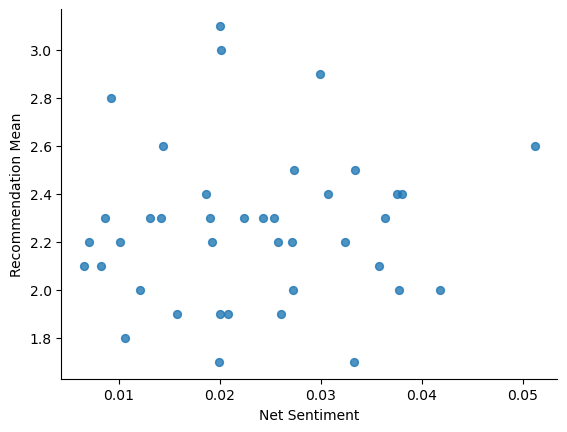

In [31]:
# net_sentiment vs recommendation_mean

plt.scatter(sent_rec_mean['net_sentiment'], sent_rec_mean['recommendation_mean'], s=32, alpha=0.8)
plt.xlabel('Net Sentiment')
plt.ylabel('Recommendation Mean')

# Hide the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [32]:
# Speaker Groups Column

In [33]:
# Volatility Column